# Simple Marketing Test

* Evolving test environment to simulate marketing to customers.
* Initially each episode is a customer, and customers have their entire lifecycle processed sequentially.

Recommend running in **jupyter notebook** as the interactive parts may not work in jupyter lab without installing and enabling certain nbextensions.

In [26]:
import random 
import numpy as np
import sys

if "../" not in sys.path:
    sys.path.append("../") 
    
from lib.envs.simple_marketing import SimpleMarketingEnv, SimpleCustomerPurchase, CustomerPurchaseVariable
from lib.simulation import Experiment

class Agent(object):  
        
    def __init__(self, actions):
        self.actions = actions
        self.num_actions = len(actions)

    def act(self, state):
        raise NotImplementedError
        
        
class SarsaAgent(Agent):
    
    def __init__(self, actions, print_rewards=True, epsilon=0.01, alpha=0.5, gamma=1):
        super(SarsaAgent, self).__init__(actions)
        
        ## TODO 1
        ## Initialize empty dictionary here
        ## In addition, initialize the value of epsilon, alpha and gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.sadict = {}
        self.progress = 0
        self.print_rewards = print_rewards
        print('Epsilon is set at %f' % self.epsilon)
        print('Alpha is set at %f' % self.alpha)
        print('Gamma is set at %f' % self.gamma)
        self.action_choices = actions
        print('Actions available are %s' % actions)
        
        
    def stateToString(self, state):
        mystring = ""
        if np.isscalar(state):
            mystring = str(state)
            #print('scalar %s becomes %s' % (state, mystring))
        else:
            for digit in state:
                mystring += str(digit)
            #print('non scalar %s becomes %s' % (state, mystring))
        return mystring    
    
    def initialize_state(self, statestr):
        self.sadict[statestr] = {}
        for action in self.action_choices:
            self.sadict[statestr][action] = 0

    def print_final_statistics(self):
        """
        Function added to allow visualization of state at end
        """
        print('sarsa state action value dictionary')
        for cntr, k in enumerate(self.sadict):
            max_action_value = -99999999
            max_action = ''
            print('%d: %s' % (cntr, k))
            vdict = self.sadict[k]
            for v in vdict:
                print('   %d: %0.2f' % (v, np.round(vdict[v],2)))
                if vdict[v] > max_action_value:
                    max_action_value = vdict[v]
                    max_action = v
            print('  max action %d with value %f' % (max_action, np.round(max_action_value)))
        
    
    def act(self, state):
        stateStr = self.stateToString(state)      
        action = np.random.randint(0, self.num_actions) 
        #print('state is %s' % stateStr)
        
        ## TODO 2
        ## Implement epsilon greedy policy here
        choice_random = random.random()
        if choice_random > self.epsilon:
            # choose best action rather than random action
            max_act = []
            max_act_val = -9999999999
            if stateStr not in self.sadict:
                # initialize if needed
                self.initialize_state(stateStr)
                    
            action_value_dict = self.sadict[stateStr]
            ##print('action_value_dict is %s' % str(action_value_dict))
            pstr = '%s--' % stateStr
            for action in action_value_dict:
                act_value = action_value_dict[action]
                if act_value >= max_act_val:
                    if act_value  == max_act_val:
                        # append tied action
                        max_act.append(action)
                    else:
                        # replace with action and new max value
                        max_act = [action]
                        max_act_val = act_value
                pstr += '%s:%f,' % (action, act_value)
              
            # substitute highest value action if any found
            if max_act != []:
                rand_tied_action_int = random.randint(0, len(max_act)-1)
                action = max_act[rand_tied_action_int]
                # print out # of choices available
                # print('%d,' % len(max_act), end=' ')
            pstr += 'action: %s' % action
            # pstr useful for debugging
            #print(pstr)
        if self.print_rewards and (action==1):
            print(action, end=' ')
        return action

    def learn(self, state1, action1, reward, state2, action2):
        print_learn = False
        
        if self.print_rewards and (reward > 0):
            print('*')
        state1Str = self.stateToString(state1)
        state2Str = self.stateToString(state2)
        if state2Str not in self.sadict:
            self.initialize_state(state2Str)
            
        ##print('state 1 is %s, state 2 is %s' % (state1Str, state2Str))
        ## TODO 3
        ## Implement the sarsa update here
        prior_value_state1 = 0
        prior_value_state2 = 0
        
        ##print('action_value_dict for state1Str is %s' % str(self.sadict[state1Str]))
        #if action1 in self.sadict[state1Str]:
        prior_value_state1 = self.sadict[state1Str][action1]
        #if action2 in self.sadict[state2Str]:
        prior_value_state2 = self.sadict[state2Str][action2]
            
        # mark adjust: if we give reward I'm not going to give credit for next state
        # because in doing this it's confusing things a bit... the scenario is over
        if False:
            if reward != 0:
                # use this for cases with terminal reward
                value_adjust = self.alpha * (reward - prior_value_state1)
            else:
                value_adjust = self.alpha * ((self.gamma * prior_value_state2) - prior_value_state1)
        else:
            value_adjust = self.alpha * (reward + (self.gamma * prior_value_state2) - prior_value_state1)
        new_val = prior_value_state1 + value_adjust
        if new_val > 0:
            if new_val > 1:
                pass # -- this was for a reward situation where new value was an issue
                #print('****************** WHOA ********************')
            if print_learn:
                print('Replacing value %f with revised %f '
                      '[alpha %f * (reward %f + gamma %f * prior_state2 %f minus prior_state1 %f)] for s:a:s*:a* (%s:%s:%s:%s)' % 
                      (prior_value_state1, new_val, self.alpha, reward, self.gamma, 
                       prior_value_state2, prior_value_state1, state1Str, action1, state2Str, action2))
                # we will print out every time to follow path
                print('gamma * prior_state2 = %f' % (self.gamma * prior_value_state2))
                print('paren value is %f * (%f + %f * %f - %f)' % (self.alpha, reward,  self.gamma , prior_value_state2, prior_value_state1))
                print('alpha adjustment is %f' % value_adjust)
                print('alternative formulation (1-alpha) * Qold + alpha*gamma*Qnew + alpha*reward')
                print('(1-%f)*%f + %f*%f*%f + %f*%f' % (self.alpha, prior_value_state1, self.alpha, self.gamma, prior_value_state2, self.alpha, reward))
                old_contrib = (1-self.alpha) * prior_value_state1
                new_contrib = self.alpha * self.gamma * prior_value_state2
                print('%f + %f + %f' % (old_contrib, new_contrib, reward))
                print(' ')
            
        # make adjustment after printing out details
        self.sadict[state1Str][action1] = new_val
        self.progress += 1
        #if self.progress % 1000 == 0:
        #    print('; progress %d' % self.progress)
        """
        SARSA Update
        Q(s,a) <- Q(s,a) + alpha * (reward + gamma * Q(s',a') - Q(s,a))
        or
        Q(s,a) <- Q(s,a) + alpha * (td_target - Q(s,a))
        or
        Q(s,a) <- Q(s,a) + alpha * td_delta
        """
        
        
import random


class QLearningAgent(Agent):
    
    def __init__(self, actions, epsilon=0.01, alpha=0.5, gamma=1):
        super(QLearningAgent, self).__init__(actions)
        
        ## TODO 1
        ## Initialize empty dictionary here
        ## In addition, initialize the value of epsilon, alpha and gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.sadict = {}
        self.progress = 0
        print('Epsilon is set at %f' % self.epsilon)
        print('Alpha is set at %f' % self.alpha)
        print('Gamma is set at %f' % self.gamma)
        self.action_choices = actions
        print('Actions available are %s' % actions)

    def initialize_state(self, statestr):
        self.sadict[statestr] = {}
        for action in self.action_choices:
            self.sadict[statestr][action] = 0

    def stateToString(self, state):
        mystring = ""
        if np.isscalar(state):
            mystring = str(state)
        else:
            for digit in state:
                mystring += str(digit)
        return mystring    

    def print_final_statistics(self):
        """
        Function added to allow visualization of state at end
        """
        print('q learning state action value dictionary')
        for cntr, k in enumerate(self.sadict):
            max_action_value = -99999999
            max_action = ''
            print('%d: %s' % (cntr, k))
            vdict = self.sadict[k]
            for v in vdict:
                print('   %d: %0.2f' % (v, np.round(vdict[v],2)))
                if vdict[v] > max_action_value:
                    max_action_value = vdict[v]
                    max_action = v
            print('  Max action %d with value %f' % (max_action, np.round(max_action_value,2)))
        
    
    def act(self, state):
        stateStr = self.stateToString(state)      
        action = np.random.randint(0, self.num_actions) 
        
        ## TODO 2
        ## Implement epsilon greedy policy here
        if random.random() > self.epsilon:
            # choose best action rather than random action
            max_act = []
            max_act_val = -9999999999
            if stateStr not in self.sadict:
                # initialize if needed
                self.initialize_state(stateStr)
                    
            action_value_dict = self.sadict[stateStr]
            ##print('action_value_dict is %s' % str(action_value_dict))
            pstr = '%s--' % stateStr
            for action in action_value_dict:
                act_value = action_value_dict[action]
                if act_value >= max_act_val:
                    if act_value  == max_act_val:
                        # append tied action
                        max_act.append(action)
                    else:
                        # replace with action and new max value
                        max_act = [action]
                        max_act_val = act_value
                pstr += '%s:%f,' % (action, act_value)
              
            # substitute highest value action if any found
            if max_act != []:
                rand_tied_action_int = random.randint(0, len(max_act)-1)
                action = max_act[rand_tied_action_int]
                # print out # of choices available
                # print('%d,' % len(max_act), end=' ')
            pstr += 'action: %s' % action
            # pstr useful for debugging
            #print(pstr)
        
        return action
    
    def learn(self, state1, action1, reward, state2, done):
        state1Str = self.stateToString(state1)
        state2Str = self.stateToString(state2)
        
        ## TODO 3
        ## Implement the q-learning update here
        if state2Str not in self.sadict:
            self.initialize_state(state2Str)
            
        prior_value_state1 = 0
        prior_value_state2 = 0
        
        prior_value_state1 = self.sadict[state1Str][action1]
        state_2_values = self.sadict[state2Str]
        argm = max(state_2_values, key=state_2_values.get)
        prior_value_state2 = state_2_values[argm]
        if False:
            print(state_2_values, end=': ')
            print('%d: %f' % (argm, prior_value_state2))
            
        value_adjust = self.alpha * (reward + (self.gamma * prior_value_state2) - prior_value_state1)
        new_val = prior_value_state1 + value_adjust
        
        # make adjustment after printing out details
        self.sadict[state1Str][action1] = new_val
        self.progress += 1
        #if self.progress % 5000 == 0:
        #    print('; progress %d' % self.progress)
        
        """
        Q-learning Update:
        Q(s,a) <- Q(s,a) + alpha * (reward + gamma * max(Q(s') - Q(s,a))
        or
        Q(s,a) <- Q(s,a) + alpha * (td_target - Q(s,a))
        or
        Q(s,a) <- Q(s,a) + alpha * td_delta
        """

# Customer Simulator

* Uses SimpleCustomerPurchase which always spends the same amount when purchasing
* Interactive

In this environment, actions 0=no marketing action, 1=marketing action
Marketing actions will only work in a range of possible steps.
Epsilon is set at 0.100000
Alpha is set at 0.500000
Gamma is set at 1.000000
Initial progress is 0
Actions available are range(0, 2)


<IPython.core.display.Javascript object>


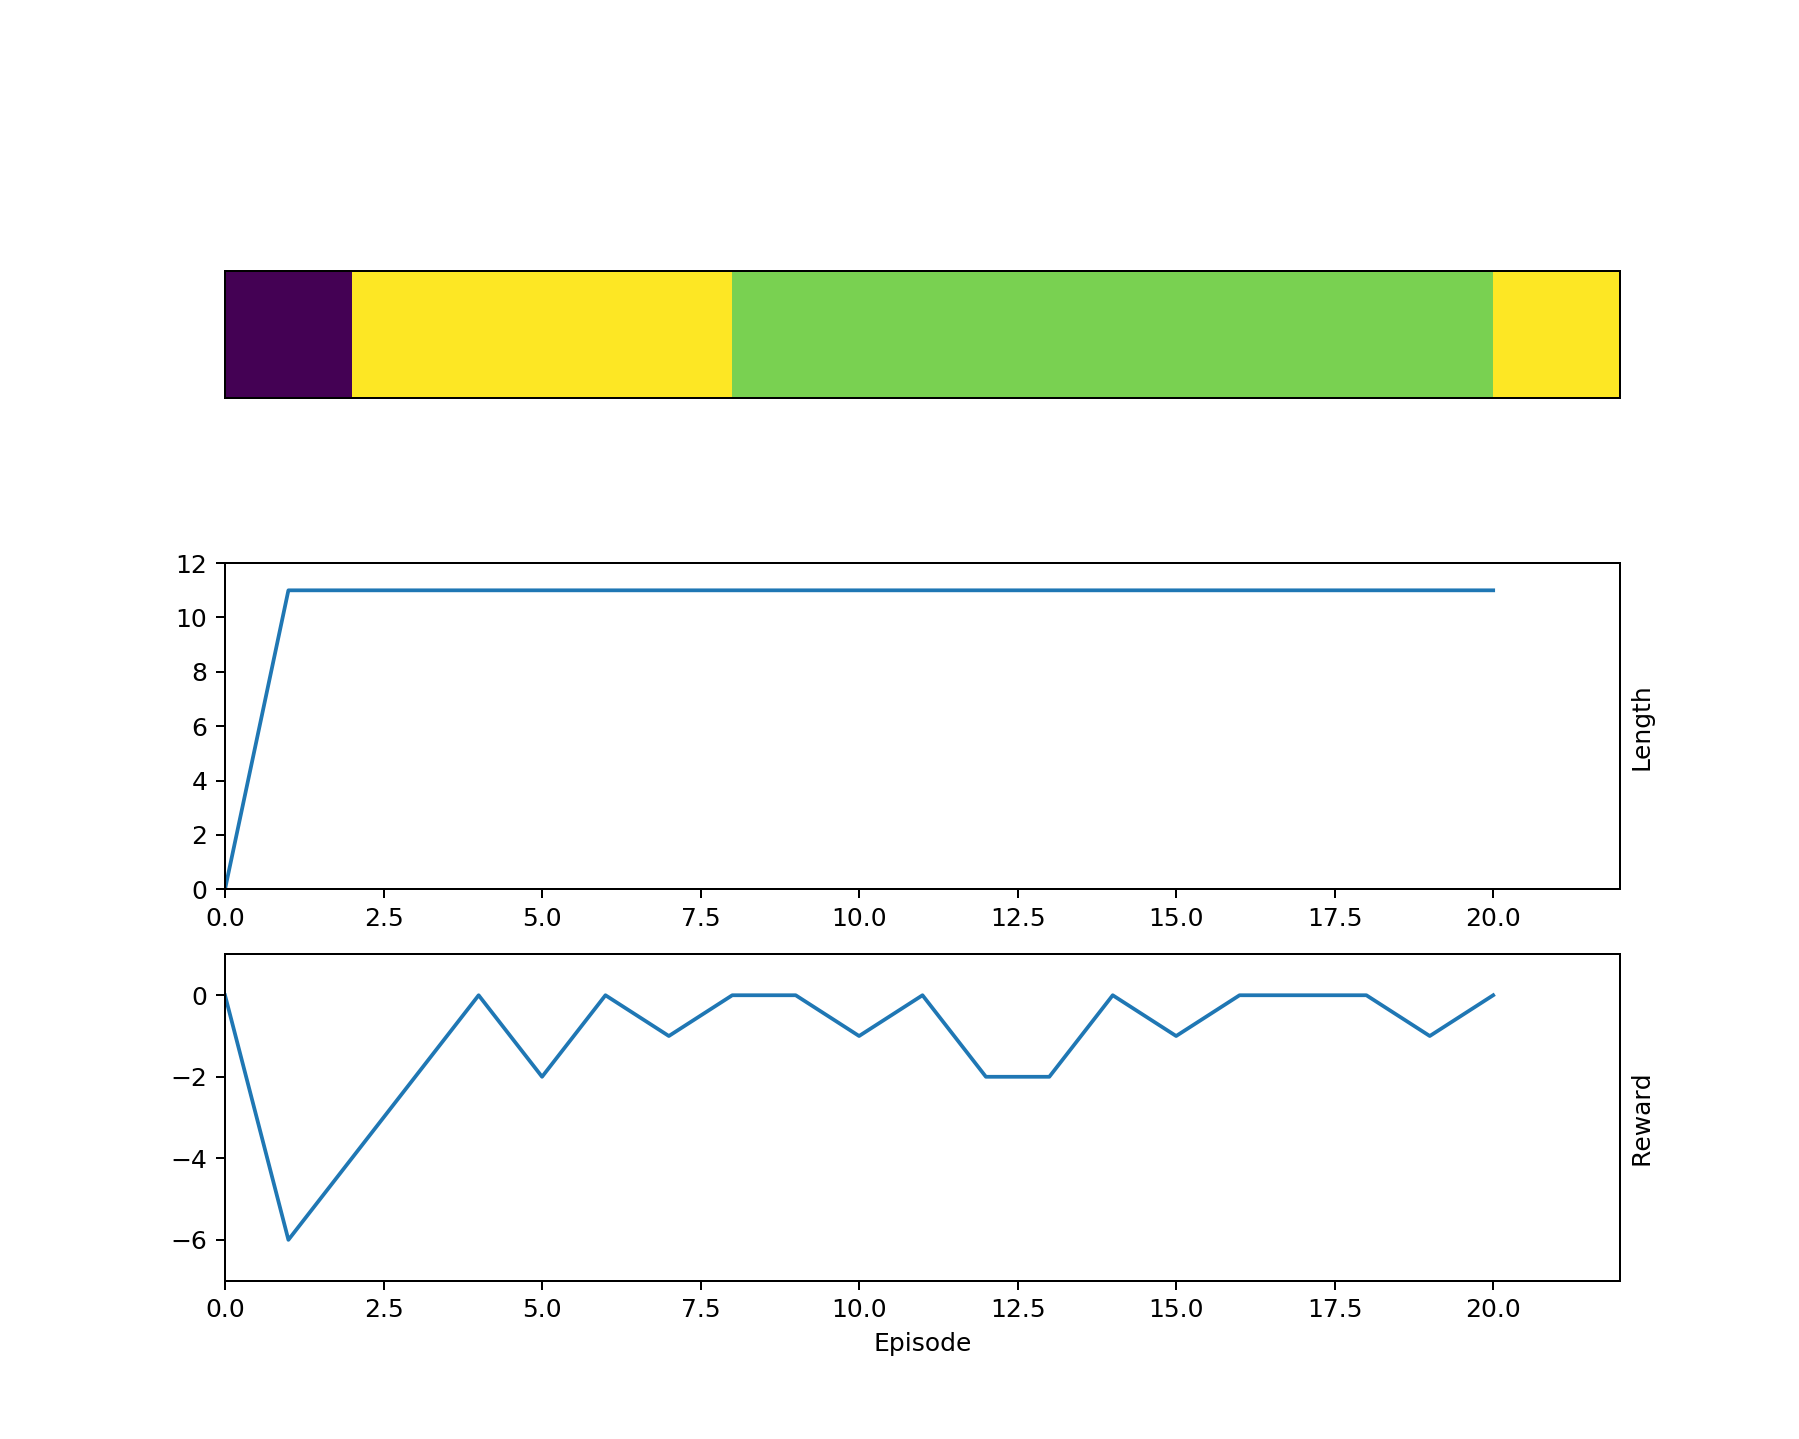

In [6]:
interactive = True
%matplotlib nbagg
episode_count = 20
cust = SimpleCustomerPurchase(tdeath=11, tmin=4, tmax=10, prob_response=0.05, gross_profit_response=100)
env = SimpleMarketingEnv(cust, cost_marketing_action=1)

#
# setup higher epsilon otherwise takes long time to learn
#
agent = QLearningAgent(range(env.action_space.n), epsilon=0.02)
experiment = Experiment(env, agent)
random.seed(42)
experiment.run_sarsa(episode_count, interactive)


* Non-interactive version

Faster to run many episodes (customers)

In this environment, actions 0=no marketing action, 1=marketing action
Marketing actions will only work in a range of possible steps.
Epsilon is set at 0.050000
Alpha is set at 0.500000
Gamma is set at 1.000000
Initial progress is 0
Actions available are range(0, 2)
; progress 5000
; progress 10000
; progress 15000
; progress 20000
; progress 25000
; progress 30000
; progress 35000
; progress 40000
; progress 45000
; progress 50000
; progress 55000
; progress 60000
; progress 65000
; progress 70000
; progress 75000
; progress 80000
; progress 85000
; progress 90000
; progress 95000
; progress 100000
; progress 105000
; progress 110000
; progress 115000
; progress 120000
; progress 125000
; progress 130000
; progress 135000
; progress 140000
; progress 145000
; progress 150000
; progress 155000
; progress 160000
; progress 165000
; progress 170000
; progress 175000
; progress 180000
; progress 185000
; progress 190000
; progress 195000


<Figure size 720x576 with 0 Axes>

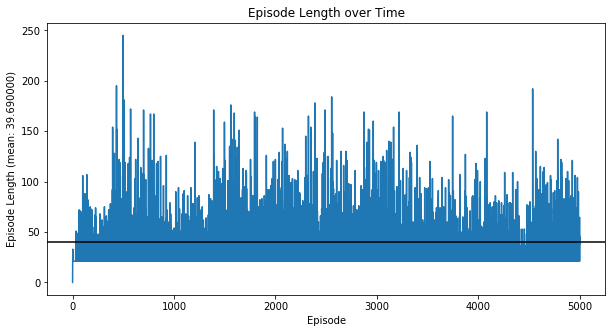

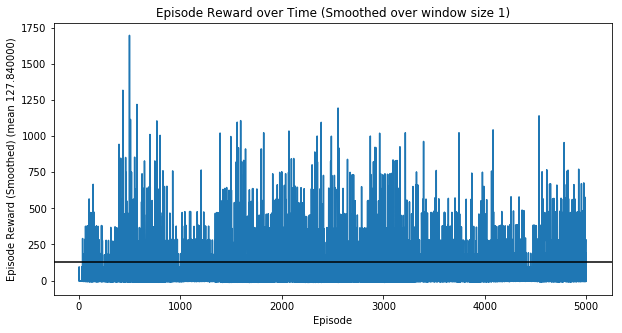

q learning state action value dictionary
0: 1.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.0
   0: 15675.07
   1: 15537.91
1: 0.01.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.0
   0: 15678.80
   1: 15561.30
2: 0.00.01.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.0
   0: 15677.79
   1: 15647.32
3: 0.00.00.01.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.0
   0: 15670.17
   1: 15570.97
4: 0.00.00.00.01.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.0
   0: 15659.60
   1: 15582.55
5: 0.00.00.00.00.01.00.00.00.00.00.00.00.00.00.00.00.00.00.00.00.0
   0: 15653.27
   1: 15579.90
6: 0.00.00.00.00.00.01.00.00.00.00.00.00.00.00.00.00.00.00.00.00.0
   0: 15653.74
   1: 15507.07
7: 0.00.00.00.00.00.00.01.00.00.00.00.00.00.00.00.00.00.00.00.00.0
   0: 15670.26
   1: 15484.97
8: 0.00.00.00.00.00.00.00.01.00.00.00.00.00.00.00.00.00.00.00.00.0
   0: 15683.57
   1: 15346.00
9: 0.00.00.00.00.00.00.00.00.01.00.00.00.00.00.00.00.00.00.00.00.0
   0: 15628.25
   1

In [15]:
interactive = False
%matplotlib inline
episode_count = 5000
cust = SimpleCustomerPurchase(tdeath=21, tmin=10, tmax=18, prob_response=0.15, gross_profit_response=100)
env = SimpleMarketingEnv(cust, cost_marketing_action=1)
agent = QLearningAgent(range(env.action_space.n),  epsilon=0.02)
experiment = Experiment(env, agent)
random.seed(42)
experiment.run_sarsa(episode_count, interactive)


### Stochastic purchase amount

* Uses CustomerPurchaseVariable to demonstrate effect of changing the amount customer has spent stochastically.

In [ ]:
interactive = True
%matplotlib nbagg
episode_count = 40
cust = CustomerPurchaseVariable(tdeath=51, tmin=25, tmax=50, prob_response=0.2, gross_profit_response_max=200)
env = SimpleMarketingEnv(cust, cost_marketing_action=1)

#
# setup higher epsilon otherwise takes long time to learn
#
agent = QLearningAgent(range(env.action_space.n),  epsilon=0.02)
experiment = Experiment(env, agent)
random.seed(42)
experiment.run_sarsa(episode_count, interactive)

In this environment, actions 0=no marketing action, 1=marketing action
Marketing actions will only work in a range of possible steps.
Epsilon is set at 0.020000
Alpha is set at 0.500000
Gamma is set at 1.000000
Actions available are range(0, 2)


<Figure size 720x576 with 0 Axes>

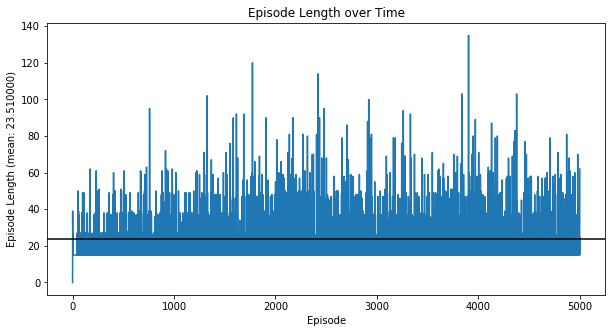

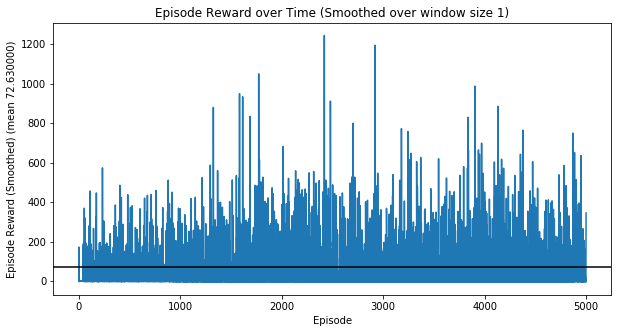

q learning state action value dictionary
0: 1.00.00.00.00.00.00.00.00.00.00.00.00.00.00.0
   0: 12490.95
   1: 12380.66
  Max action 0 with value 12490.953704
1: 0.01.00.00.00.00.00.00.00.00.00.00.00.00.00.0
   0: 12485.13
   1: 12427.08
  Max action 0 with value 12485.132775
2: 0.00.01.00.00.00.00.00.00.00.00.00.00.00.00.0
   0: 12480.66
   1: 12262.29
  Max action 0 with value 12480.656444
3: 0.00.00.01.00.00.00.00.00.00.00.00.00.00.00.0
   0: 12479.03
   1: 12332.45
  Max action 0 with value 12479.034975
4: 0.00.00.00.01.00.00.00.00.00.00.00.00.00.00.0
   0: 12482.89
   1: 12367.56
  Max action 0 with value 12482.892527
5: 0.00.00.00.00.01.00.00.00.00.00.00.00.00.00.0
   0: 12492.68
   1: 12234.07
  Max action 0 with value 12492.681677
6: 0.00.00.00.00.00.01.00.00.00.00.00.00.00.00.0
   0: 12500.01
   1: 12312.55
  Max action 0 with value 12500.011333
7: 0.00.00.00.00.00.00.01.00.00.00.00.00.00.00.0
   0: 12501.35
   1: 12429.18
  Max action 0 with value 12501.353494
8: 0.00.00.00.0

In [25]:
interactive = False
%matplotlib inline
episode_count =  5000
cust = CustomerPurchaseVariable(tdeath=15, tmin=10, tmax=13, prob_response=0.2, gross_profit_response_max=200,
                               own_purchase_prob=0.005, prob_sudden_death = 0.005)
env = SimpleMarketingEnv(cust, cost_marketing_action=1)

#
# setup higher epsilon otherwise takes long time to learn
#
agent = QLearningAgent(range(env.action_space.n), epsilon=0.02)
experiment = Experiment(env, agent)
random.seed(42)
experiment.run_sarsa(episode_count, interactive)